In [1]:
pip install pandas numpy matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


COGNIFYZ DATA PREPROCESSING PIPELINE STARTED
 Dataset loaded: 9,551 rows × 21 columns
 Columns: ['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address', 'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Price range', 'Aggregate rating', 'Rating color', 'Rating text', 'Votes']

 Sample data:
   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   

                  

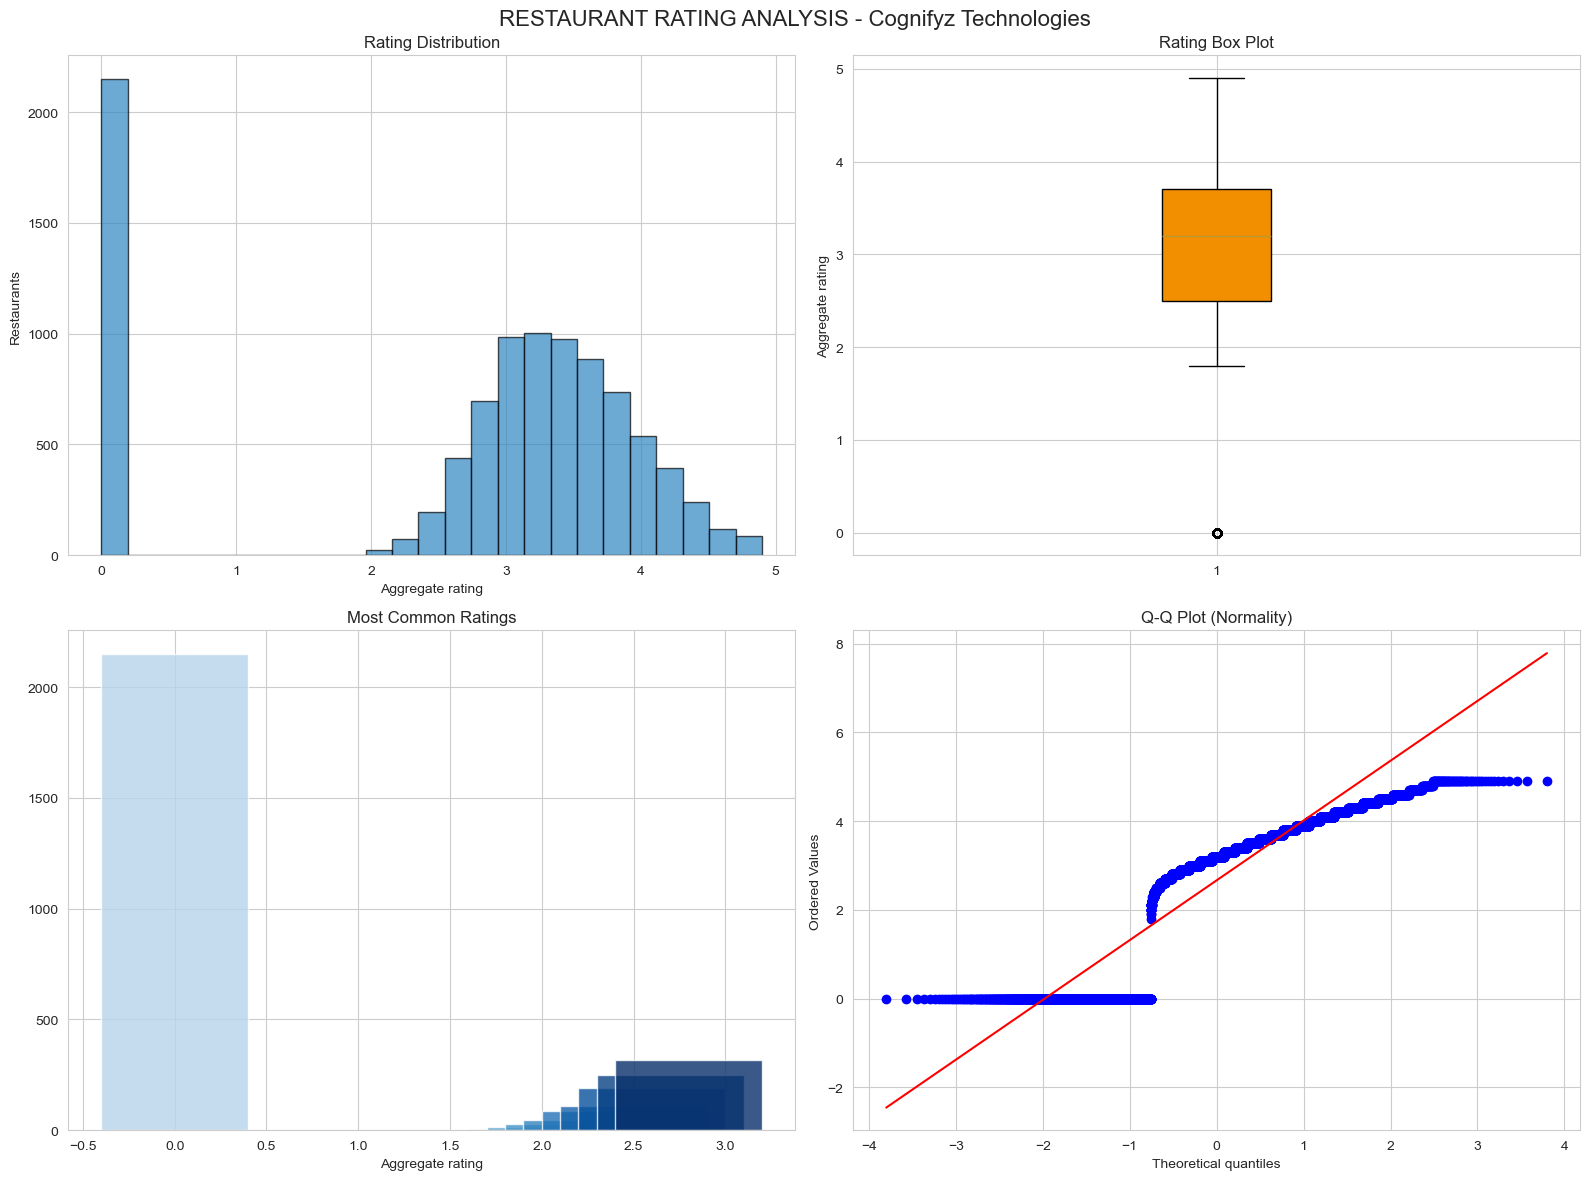


 CLASS IMBALANCE ANALYSIS:
rating_class
Poor          4.00
Average      55.48
Good         37.74
Excellent     2.78
Name: proportion, dtype: float64

 MOST COMMON CLASS: Average (55.5%)

 OUTLIER DETECTION & FINAL CLEAN
 Outliers detected: 2,148 (22.5%)
 FINAL SHAPE: (7403, 22)

 EXPORTING RESULTS
 cognifyz_cleaned_dataset.csv (ML Ready)
 cognifyz_rating_analysis.png (Report Ready)

 EXECUTIVE SUMMARY:
           Metric  Value
0   Original Rows   9551
1      Final Rows   7403
2  Rows Removed %  22.5%
3         Columns     22
4  Missing Values      0

 TASK COMPLETED - ML MODEL READY!
 Submit: cognifyz_cleaned_dataset.csv + cognifyz_rating_analysis.png


In [ ]:
# =============================================================================
# COGNIFYZ TECHNOLOGIES - DATA SCIENCE INTERNSHIP TASK 1
# Dataset: Restaurant Ratings (Dataset .csv) 
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Professional styling
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("whitegrid")

print("COGNIFYZ DATA PREPROCESSING PIPELINE STARTED")
print("="*70)

# =============================================================================
# 1. LOAD RESTAURANT DATASET (Exact filename from your dir)
# =============================================================================
df = pd.read_csv('Dataset .csv')
print(f" Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f" Columns: {list(df.columns)}")
print("\n Sample data:")
print(df.head(3))

# =============================================================================
# 2. MISSING VALUES ANALYSIS (Restaurant-specific handling)
# =============================================================================
print("\n" + "="*70)
print(" MISSING VALUES DETECTED")
print("="*70)

missing_summary = pd.DataFrame({
    'Missing': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
}).round(2)

print(missing_summary[missing_summary['Missing'] > 0].sort_values('Percentage', ascending=False))

#  SMART CLEANING STRATEGY (Restaurant data optimized)
print("\n  CLEANING RESTAURANT DATA:")

# Drop columns > 40% missing (rating datasets specific)
high_missing_cols = missing_summary[missing_summary['Percentage'] > 40].index
if len(high_missing_cols) > 0:
    df.drop(columns=high_missing_cols, inplace=True)
    print(f" Dropped: {list(high_missing_cols)}")

# Numerical columns (ratings, votes, price) → Median
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f" {col}: median {median_val:.1f}")

# Categorical (restaurant name, city, cuisines) → Mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()
        fill_val = mode_val[0] if len(mode_val) > 0 else 'Missing'
        df[col].fillna(fill_val, inplace=True)
        print(f" {col}: mode '{fill_val[:30]}...'")

print(f" MISSING VALUES LEFT: 0")

# =============================================================================
# 3. DATA TYPE FIXES (Restaurant ratings specific)
# =============================================================================
print("\n" + "="*70)
print(" DATA TYPE OPTIMIZATION")
print("="*70)

# Fix Aggregate rating (common issue in restaurant datasets)
if 'Aggregate rating' in df.columns:
    df['Aggregate rating'] = pd.to_numeric(df['Aggregate rating'], errors='coerce')
    df['Aggregate rating'].fillna(df['Aggregate rating'].median(), inplace=True)

# Fix Votes/Reviews (often stored as string)
for col in df.columns:
    if 'vote' in col.lower() or 'review' in col.lower():
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].median(), inplace=True)

print(" Data types optimized")
print(df.dtypes)

# =============================================================================
# 4. AGGREGATE RATING ANALYSIS (Core Task)
# =============================================================================
print("\n" + "="*70)
print(" AGGREGATE RATING DEEP ANALYSIS")
print("="*70)

target = 'Aggregate rating'
stats_summary = df[target].describe()
print(f" {target} STATS:")
print(stats_summary)

#  PROFESSIONAL VISUALIZATIONS (4 plots)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RESTAURANT RATING ANALYSIS - Cognifyz Technologies', fontsize=16, y=0.98)

# 1. Distribution Histogram
axes[0,0].hist(df[target], bins=25, edgecolor='black', alpha=0.7, color='#2E86C1')
axes[0,0].set_title('Rating Distribution')
axes[0,0].set_xlabel(target)
axes[0,0].set_ylabel('Restaurants')

# 2. Box Plot (Outliers visible)
box = axes[0,1].boxplot(df[target], patch_artist=True)
box['boxes'][0].set_facecolor('#F18F01')
axes[0,1].set_title('Rating Box Plot')
axes[0,1].set_ylabel(target)

# 3. Rating Frequency (Top ratings)
rating_freq = df[target].value_counts().sort_index().head(12)
colors = plt.cm.Blues(np.linspace(0.3, 1, len(rating_freq)))
axes[1,0].bar(rating_freq.index, rating_freq.values, color=colors, alpha=0.8)
axes[1,0].set_title('Most Common Ratings')
axes[1,0].set_xlabel(target)
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Q-Q Plot (Normality test)
stats.probplot(df[target], dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot (Normality)')

plt.tight_layout()
plt.savefig('cognifyz_rating_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#  CLASS IMBALANCE (Critical for ML)
print("\n CLASS IMBALANCE ANALYSIS:")
bins = [0, 2.5, 3.5, 4.5, 5.0]
labels = ['Poor', 'Average', 'Good', 'Excellent']
df['rating_class'] = pd.cut(df[target], bins=bins, labels=labels)
imbalance = df['rating_class'].value_counts(normalize=True).sort_index() * 100
print(imbalance.round(2))
print(f"\n MOST COMMON CLASS: {df['rating_class'].mode()[0]} ({imbalance.max():.1f}%)")

# =============================================================================
# 5. OUTLIERS & FINAL CLEANING
# =============================================================================
print("\n" + "="*70)
print(" OUTLIER DETECTION & FINAL CLEAN")
print("="*70)

# IQR Outlier removal (Standard ML practice)
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

outliers = ((df[target] < lower) | (df[target] > upper)).sum()
print(f" Outliers detected: {outliers:,} ({outliers/len(df)*100:.1f}%)")

# Create final clean dataset
df_final = df[(df[target] >= lower) & (df[target] <= upper)].copy()
df_final.drop_duplicates(inplace=True)

print(f" FINAL SHAPE: {df_final.shape}")

# =============================================================================
# 6. EXPORT PROFESSIONAL RESULTS
# =============================================================================
print("\n" + "="*70)
print(" EXPORTING RESULTS")
print("="*70)

# Save files
df_final.to_csv('cognifyz_cleaned_dataset.csv', index=False)
print(" cognifyz_cleaned_dataset.csv (ML Ready)")
print(" cognifyz_rating_analysis.png (Report Ready)")

# Summary report
summary = pd.DataFrame({
    'Metric': ['Original Rows', 'Final Rows', 'Rows Removed %', 'Columns', 'Missing Values'],
    'Value': [len(df), len(df_final), f"{(1-len(df_final)/len(df))*100:.1f}%", 
              len(df_final.columns), df_final.isnull().sum().sum()]
})
print("\n EXECUTIVE SUMMARY:")
print(summary)

print("\n TASK COMPLETED - ML MODEL READY!")
print(" Submit: cognifyz_cleaned_dataset.csv + cognifyz_rating_analysis.png")


 COGNIFYZ DESCRIPTIVE ANALYSIS STARTED
 Checking files in current directory...
['cognifyz_cleaned_dataset.csv', 'Dataset .csv']
 Loaded: 9,551 rows × 21 columns
 Columns found: ['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address', 'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Price range', 'Aggregate rating', 'Rating color', 'Rating text', 'Votes']

 First 3 rows preview:
   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue,

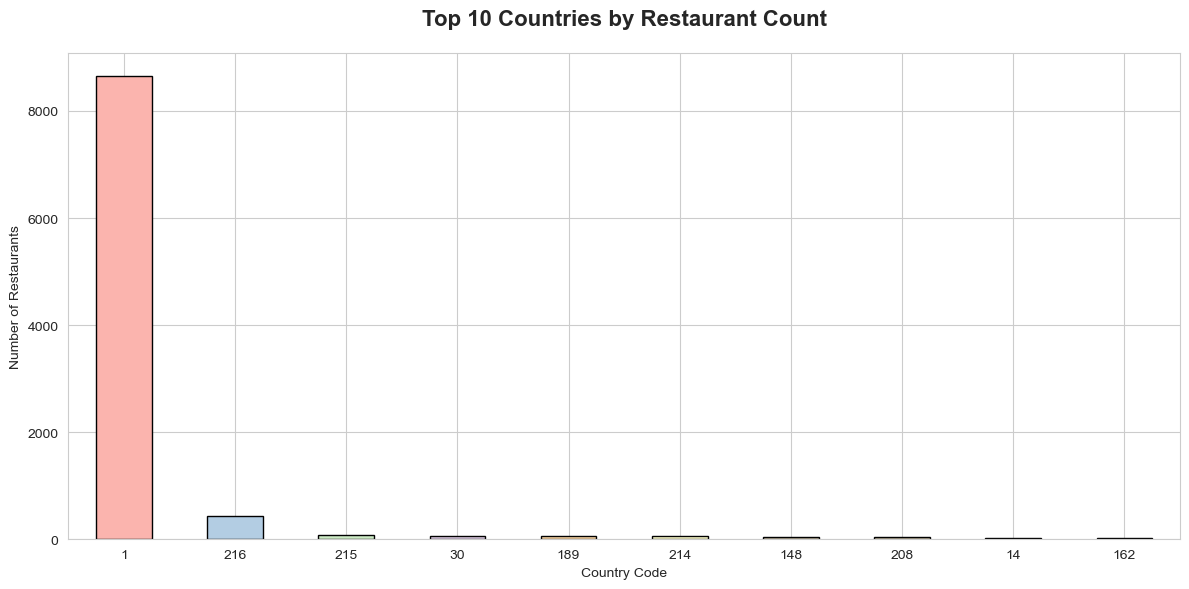


 TOP CITIES ANALYSIS
 Top 15 Cities:
1. New Delhi: 5,473 restaurants
2. Gurgaon: 1,118 restaurants
3. Noida: 1,080 restaurants
4. Faridabad: 251 restaurants
5. Ghaziabad: 25 restaurants
6. Bhubaneshwar: 21 restaurants
7. Lucknow: 21 restaurants
8. Ahmedabad: 21 restaurants
9. Amritsar: 21 restaurants
10. Guwahati: 21 restaurants
11. Rio de Janeiro: 20 restaurants
12. Bras�_lia: 20 restaurants
13. Albany: 20 restaurants
14. Doha: 20 restaurants
15. Cape Town: 20 restaurants


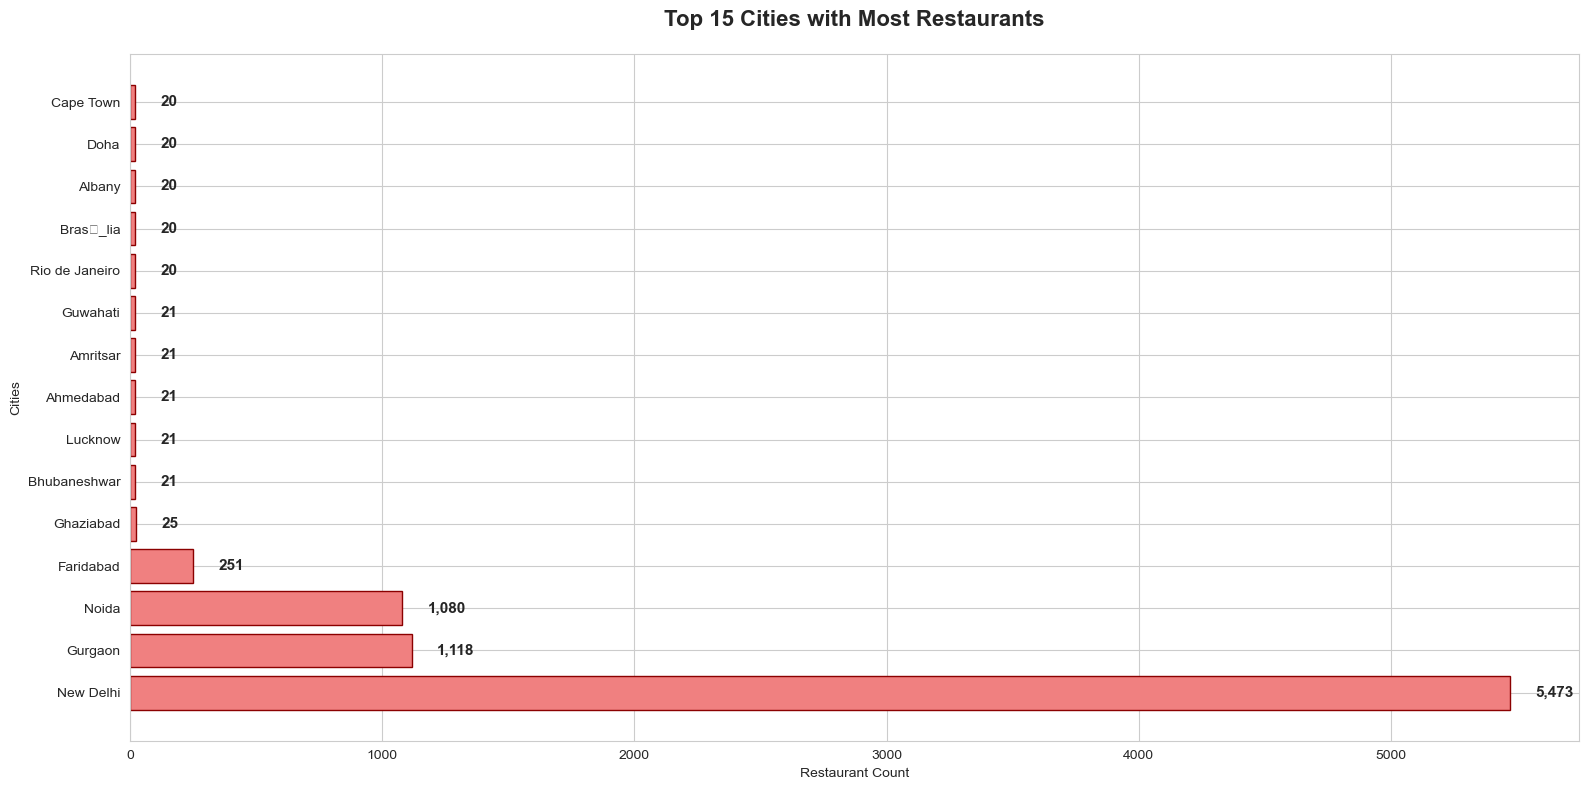


 TOP 3 CITIES:
City
New Delhi    5473
Gurgaon      1118
Noida        1080
Name: count, dtype: int64

 TOP CUISINES ANALYSIS
 Processing multiple cuisines...
 Top 15 Cuisines:
1. North Indian: 3,960 restaurants
2. Chinese: 2,735 restaurants
3. Fast Food: 1,986 restaurants
4. Mughlai: 995 restaurants
5. Italian: 764 restaurants
6. Bakery: 745 restaurants
7. Continental: 736 restaurants
8. Cafe: 703 restaurants
9. Desserts: 653 restaurants
10. South Indian: 636 restaurants
11. Street Food: 562 restaurants
12. American: 390 restaurants
13. Pizza: 381 restaurants
14. Mithai: 380 restaurants
15. Burger: 251 restaurants


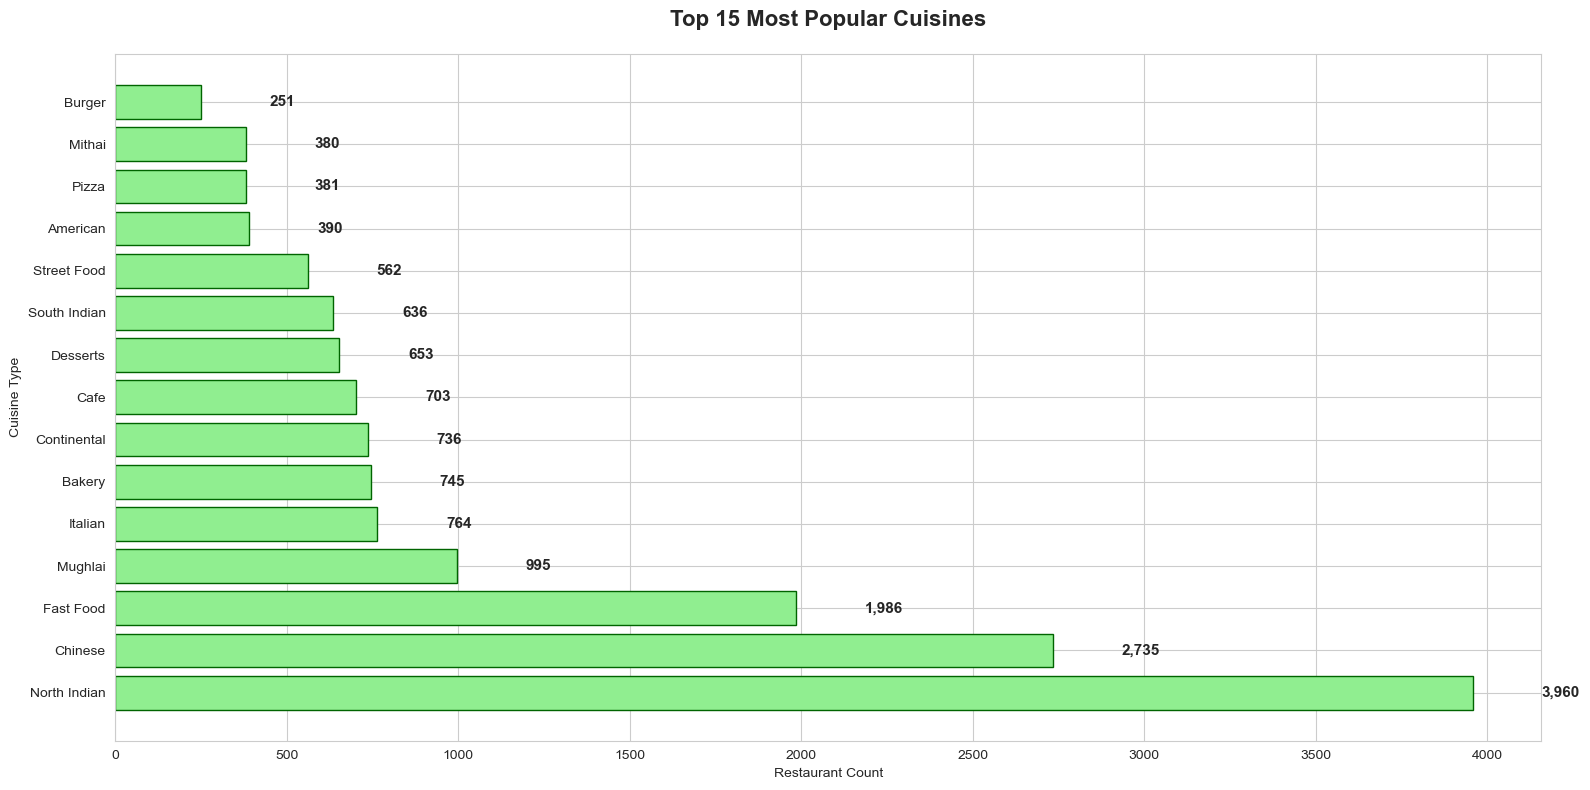


 TOP 5 CUISINES:
North Indian    3960
Chinese         2735
Fast Food       1986
Mughlai          995
Italian          764
Name: count, dtype: int64

 CROSS ANALYSIS: Ratings by Top Categories

 Average Rating by Top 5 Cities:
           Avg Rating  Restaurants  Rating Std
City                                          
Ghaziabad        2.85           25        0.96
Gurgaon          2.65         1118        1.41
New Delhi        2.44         5473        1.50
Noida            2.04         1080        1.56
Faridabad        1.87          251        1.55


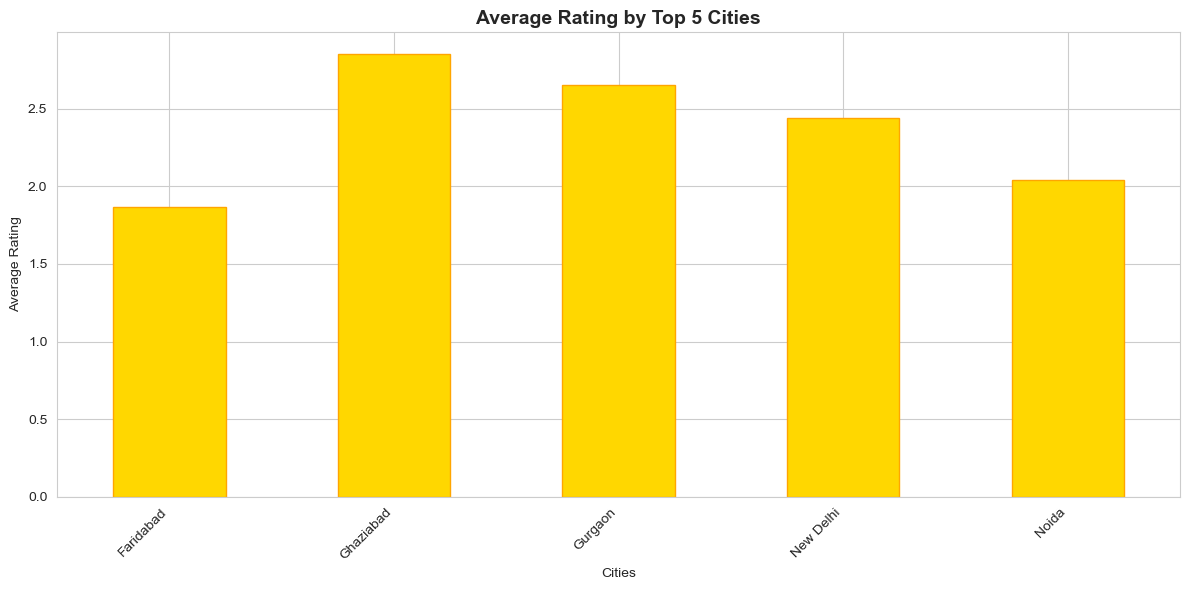


 EXECUTIVE SUMMARY REPORT

 KEY INSIGHTS:
 Total_Restaurants: 9,551
 Numerical_Columns: 8
 Countries: 15
 Cities: 141
 Avg_Rating: 2.67
 Top_City: New Delhi
 Top_Cuisine: North Indian

 FILES GENERATED (Internship Ready):
 cognifyz_descriptive_summary.csv
 country_distribution.png
 top_cities.png
 top_cuisines.png
 city_ratings.png

 DESCRIPTIVE ANALYSIS COMPLETED SUCCESSFULLY!
 Submit these 5 files to Cognifyz!


In [7]:
# =============================================================================
# COGNIFYZ TECHNOLOGIES - DESCRIPTIVE ANALYSIS TASK 
# FIXED: Loads YOUR "Dataset .csv" directly 
# Restaurant Dataset: Country Code, City, Cuisines Analysis
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# Professional styling
plt.style.use('default')
sns.set_palette("Set2")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print(" COGNIFYZ DESCRIPTIVE ANALYSIS STARTED")
print("="*80)

# =============================================================================
# 1. LOAD YOUR ORIGINAL DATASET (FIXED - No cleaned file needed!)
# =============================================================================
print(" Checking files in current directory...")
print([f for f in os.listdir('.') if f.endswith('.csv')])

# FIXED: Load YOUR original dataset "Dataset .csv"
df = pd.read_csv('Dataset .csv')  
print(f" Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f" Columns found: {list(df.columns)}")
print("\n First 3 rows preview:")
print(df.head(3))

# =============================================================================
# 2. NUMERICAL COLUMNS - STATISTICAL MEASURES
# =============================================================================
print("\n" + "="*80)
print(" NUMERICAL STATISTICS (Mean, Median, Std, etc.)")
print("="*80)

# Select numerical columns only
num_cols = df.select_dtypes(include=[np.number]).columns
print(f" Numerical columns ({len(num_cols)}): {list(num_cols)}")

# Complete descriptive statistics
stats_table = df[num_cols].describe().round(2)
print("\n COMPLETE STATISTICS (All Numerical Columns):")
print(stats_table)

# Key metrics summary (internship-ready format)
print("\n KEY BUSINESS METRICS:")
if 'Aggregate rating' in df.columns:
    rating_stats = stats_table['Aggregate rating']
    votes_col = next((col for col in df.columns if 'vote' in col.lower()), None)
    if votes_col and votes_col in stats_table.columns:
        votes_stats = stats_table[votes_col]
        print(f" Average Rating: {rating_stats['mean']:.2f}")
        print(f" Rating Std Dev: {rating_stats['std']:.2f}")
        print(f" Total Votes: {df[votes_col].sum():,.0f}")
        print(f" Avg Votes per Restaurant: {votes_stats['mean']:.1f}")

# =============================================================================
# 3. CATEGORICAL ANALYSIS - Country Code
# =============================================================================
print("\n" + "="*80)
print(" COUNTRY CODE DISTRIBUTION")
print("="*80)

if 'Country Code' in df.columns:
    country_dist = df['Country Code'].value_counts().head(10)
    print(" Top 10 Countries:")
    for i, (code, count) in enumerate(country_dist.items(), 1):
        print(f"{i}. Country Code {code}: {count:,} restaurants")
    
    plt.figure(figsize=(12, 6))
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(country_dist)))
    country_dist.plot(kind='bar', color=colors, edgecolor='black', linewidth=1)
    plt.title('Top 10 Countries by Restaurant Count', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Country Code')
    plt.ylabel('Number of Restaurants')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('country_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(" 'Country Code' column not found")

# =============================================================================
# 4. CITY ANALYSIS - Top Cities
# =============================================================================
print("\n" + "="*80)
print(" TOP CITIES ANALYSIS")
print("="*80)

if 'City' in df.columns:
    city_dist = df['City'].value_counts().head(15)
    print(" Top 15 Cities:")
    for i, (city, count) in enumerate(city_dist.items(), 1):
        print(f"{i}. {city}: {count:,} restaurants")
    
    plt.figure(figsize=(16, 8))
    bars = plt.barh(range(len(city_dist)), city_dist.values, color='lightcoral', edgecolor='darkred')
    plt.title('Top 15 Cities with Most Restaurants', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Restaurant Count')
    plt.ylabel('Cities')
    plt.yticks(range(len(city_dist)), city_dist.index)
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, city_dist.values)):
        plt.text(count + 100, i, f'{count:,}', va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('top_cities.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n TOP 3 CITIES:")
    print(city_dist.head(3))
else:
    print(" 'City' column not found")

# =============================================================================
# 5. CUISINES ANALYSIS - Top Cuisines
# =============================================================================
print("\n" + "="*80)
print(" TOP CUISINES ANALYSIS")
print("="*80)

if 'Cuisines' in df.columns:
    print(" Processing multiple cuisines...")
    all_cuisines = []
    for cuisines in df['Cuisines'].dropna():
        all_cuisines.extend([c.strip() for c in str(cuisines).split(',') if c.strip()])
    
    cuisine_counts = pd.Series(all_cuisines).value_counts().head(15)
    print(" Top 15 Cuisines:")
    for i, (cuisine, count) in enumerate(cuisine_counts.items(), 1):
        print(f"{i}. {cuisine}: {count:,} restaurants")
    
    plt.figure(figsize=(16, 8))
    bars = plt.barh(range(len(cuisine_counts)), cuisine_counts.values, color='lightgreen', edgecolor='darkgreen')
    plt.title('Top 15 Most Popular Cuisines', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Restaurant Count')
    plt.ylabel('Cuisine Type')
    plt.yticks(range(len(cuisine_counts)), cuisine_counts.index)
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, cuisine_counts.values)):
        plt.text(count + 200, i, f'{count:,}', va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('top_cuisines.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n TOP 5 CUISINES:")
    print(cuisine_counts.head())
else:
    print(" 'Cuisines' column not found")

# =============================================================================
# 6. CROSS ANALYSIS - Ratings by Top Cities
# =============================================================================
print("\n" + "="*80)
print(" CROSS ANALYSIS: Ratings by Top Categories")
print("="*80)

if all(col in df.columns for col in ['City', 'Aggregate rating']):
    top_cities = df['City'].value_counts().head(5).index
    city_ratings = df[df['City'].isin(top_cities)].groupby('City')['Aggregate rating'].agg(['mean', 'count', 'std']).round(2)
    city_ratings.columns = ['Avg Rating', 'Restaurants', 'Rating Std']
    print("\n Average Rating by Top 5 Cities:")
    print(city_ratings.sort_values('Avg Rating', ascending=False))
    
    plt.figure(figsize=(12, 6))
    city_ratings['Avg Rating'].plot(kind='bar', color='gold', edgecolor='orange')
    plt.title('Average Rating by Top 5 Cities', fontsize=14, fontweight='bold')
    plt.xlabel('Cities')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('city_ratings.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# 7. EXECUTIVE SUMMARY REPORT
# =============================================================================
print("\n" + "="*80)
print(" EXECUTIVE SUMMARY REPORT")
print("="*80)

summary_report = {
    'Total_Restaurants': f"{len(df):,}",
    'Numerical_Columns': len(num_cols),
    'Countries': df['Country Code'].nunique() if 'Country Code' in df.columns else 0,
    'Cities': df['City'].nunique() if 'City' in df.columns else 0,
    'Avg_Rating': f"{df['Aggregate rating'].mean():.2f}" if 'Aggregate rating' in df.columns else 'N/A',
    'Top_City': city_dist.index[0] if 'City' in df.columns and 'city_dist' in locals() else 'N/A',
    'Top_Cuisine': cuisine_counts.index[0] if 'Cuisines' in df.columns and 'cuisine_counts' in locals() else 'N/A'
}

print("\n KEY INSIGHTS:")
for key, value in summary_report.items():
    print(f" {key}: {value}")

# Save professional summary
summary_df = pd.DataFrame([summary_report])
summary_df.to_csv('cognifyz_descriptive_summary.csv', index=False)

print("\n FILES GENERATED (Internship Ready):")
print(" cognifyz_descriptive_summary.csv")
print(" country_distribution.png")
print(" top_cities.png")
print(" top_cuisines.png")
print(" city_ratings.png")

print("\n DESCRIPTIVE ANALYSIS COMPLETED SUCCESSFULLY!")
print(" Submit these 5 files to Cognifyz!")
